# Analysis of A/B Test Results

### Alternate_Hypothesis
H0: There is no difference in conversion between control group and test group

H1: The variant increases conversion rate

### we change the status quo if we have the uplift of 5% with 95% of confidence

#### Importing required libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss 
import matplotlib.pyplot as plt
from scipy.stats import binom
import scipy.stats as stats
import numpy as np
import seaborn as sns
from scipy.stats import norm

#### For an A/B experiment we follow the following procedures.
1. Initially we setup the experiment and run the experiment
2. We collect the data and prepare the data
3. We visualize the obtained results
4. Analyse the results of the obtained results
5. Draw conclusion from the analysis

#### Here task is to analyse and draw conclusions from the analysis

In [2]:
df = pd.read_csv('analyst_homework_ab_test_results.csv')

In [3]:
df.head()
len(df)

199142

In [4]:
print('Visitor of the page(both variant and original) is {}.'.format(len(df)))

Visitor of the page(both variant and original) is 199142.


In [5]:
prop_users_converted = round(df.converted.mean() * 100)
print('The proportion of visitor of the page converted is {}%.'.format(prop_users_converted))

The proportion of visitor of the page converted is 7.0%.


#### Looking at the conversion rate and other metrics to have a basic idea of which design wins

In [7]:
#standard deviation
standard_p = lambda x: np.std(x, ddof=0)    
#standarda error
standard_e_p = lambda x: stats.sem(x, ddof=0)            

c_rate = df.groupby('segment')['converted'].agg([np.mean, standard_p, standard_e_p])
c_rate.columns = ['conversion_rate', 'std_deviation', 'std_error']

print(c_rate)

          conversion_rate  std_deviation  std_error
segment                                            
original         0.071197       0.257154   0.000816
variant          0.076068       0.265106   0.000840


#### Plotting the Conversion rate of the segment to visualize the result


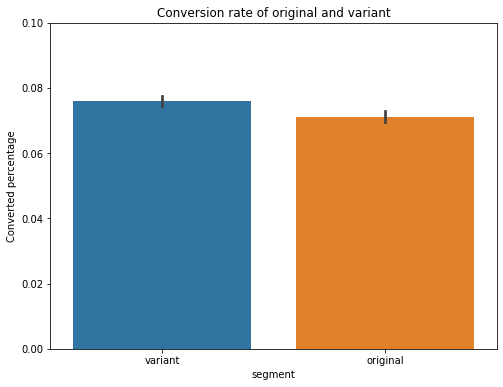

In [8]:
plt.figure(figsize=(8,6))
sns.barplot(x=df['segment'], y=df['converted'])
plt.ylim(0, 0.10)
plt.title('Conversion rate of original and variant')
plt.xlabel('segment')
plt.ylabel('Converted percentage');

#### Basic analysis


* From the result above the variant showed plausible difference. 
* The conversion rate for the original segment is around 7.1% where as the conversion rate for the variant is around 7.6%. 
* So we know the the variant performed better but how do we know if this value is statistically significant?

In [9]:
A_original, B_variant = len(df.query("segment == 'original'")),len(df.query("segment == 'variant'"))
Total_conversions = df.query('converted == 1.0')['customer_id'].nunique()
A_original_conversions = df.query('converted == 1.0 and segment == "original"')['customer_id'].nunique()
B_variant_conversions = df.query('converted == 1.0 and segment == "variant"')['customer_id'].nunique()
conversion_rate_A,conversion_rate_B = A_original_conversions / A_original, B_variant_conversions / B_variant
print(conversion_rate_A,conversion_rate_B)
print(A_original,B_variant)
print(conversion_rate_A,conversion_rate_B)

0.07119724826004747 0.07606755320215818
99428 99714
0.07119724826004747 0.07606755320215818


### Plotting the distribution

#### The standard deviation formulae used below
\begin{equation}
\text { standard deviation } \sigma=\sqrt{\frac{p(1-p)}{n}}
\end{equation}

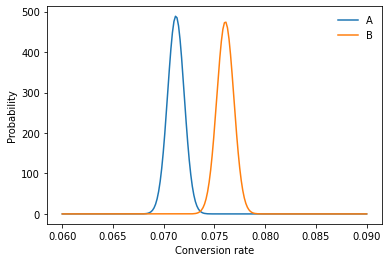

In [10]:
# Use our conversion rate values to calculate the standard deviation as above metioned formulae
std_a = np.sqrt(conversion_rate_A * (1 - conversion_rate_A) / A_original)
std_b = np.sqrt(conversion_rate_B * (1 - conversion_rate_B) / B_variant)
# Generate a range of values across the distribution sd around the mean
Conversion_rate = np.linspace(0.06, 0.09, 200)
# calculating the probabilities across the distributioin of conversion rates
# this function converts values to probabilities from Normal distribution
prob_a = ss.norm(conversion_rate_A, std_a).pdf(Conversion_rate)
prob_b = ss.norm(conversion_rate_B, std_b).pdf(Conversion_rate)
#Plotting a distribution
plt.plot(Conversion_rate, prob_a, label="A")
plt.plot(Conversion_rate, prob_b, label="B")
plt.legend(frameon=False)
plt.xlabel("Conversion rate"); plt.ylabel("Probability");

ci 95% for control group: [0.070, 0.073]
ci 95% for treatment group: [0.074, 0.078]


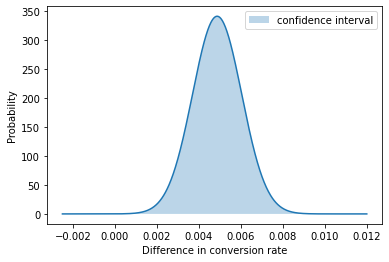

In [11]:
#Plotting the confidence interval
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

z_score = (conversion_rate_B - conversion_rate_A) / np.sqrt(std_a**2 + std_b**2)
p = norm(conversion_rate_B - conversion_rate_A, np.sqrt(std_a**2 + std_b**2))

x = np.linspace(-0.0025, 0.012, 1000)
y = p.pdf(x)
area_under_curve = p.sf(0)
plt.plot(x, y)
plt.fill_between(x, 0, y, where=x>0, label="confidence interval", alpha=0.3)
plt.legend()
plt.xlabel("Difference in conversion rate")
plt.ylabel("Probability")

convs = [A_original_conversions,B_variant_conversions]
total = [A_original, B_variant]

z_stat, pval = proportions_ztest(convs, nobs=total)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(convs, nobs=total, alpha=0.05)
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

In [12]:
#checking the confidance value of the ab test
def get_confidence_ab_test(std_a, std_b, conversion_rate_A, A_original, conversion_rate_B, B_variant):
    z_score = (conversion_rate_B - conversion_rate_A) / np.sqrt(std_a**2 + std_b**2)
    return norm.cdf(z_score)
print(get_confidence_ab_test(std_a,std_b,conversion_rate_A, A_original, conversion_rate_B, B_variant))

0.9999841648831467


# Looking at the confidence value and the pvalue which is less than 0.05, our results are statistically significant and so we can be sure that the variant version outperforms the original version. 

#### we can use other scipy libraries to check the hypothesis for convinience like  mannwhitneyu and Welsch’s t-test

In [13]:
from scipy.stats import mannwhitneyu
a_dist = np.zeros(A_original)
a_dist[:A_original_conversions] = 1
b_dist = np.zeros(B_variant)
b_dist[:B_variant_conversions] = 1
stat, p_value = mannwhitneyu(a_dist, b_dist, alternative="less")
print(f"Mann-Whitney U test for null hypothesis of version B out performing A is {p_value}")

Mann-Whitney U test for null hypothesis of version B out performing A is 1.586102735394054e-05


#### Answering the Questions.
Given the data provided and assuming that we have run the experiment long enough:
* Should we change the current status quo? Why?

#### Since it is clear that the variant version outperforms the original version, we can reject the null hypothesis and change the status quo
#### The uplift is 6.840580305% which is more 5% so it is safe to roll out the new version.